In [1]:
import numpy
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as np
map_base_dir = 'input/'
map_img_dir = 'input/train/images/'

In [2]:
json_path = os.path.join(map_base_dir, 'annotation.json')
with open(json_path, 'r') as f:
    annot_data = json.load(f)

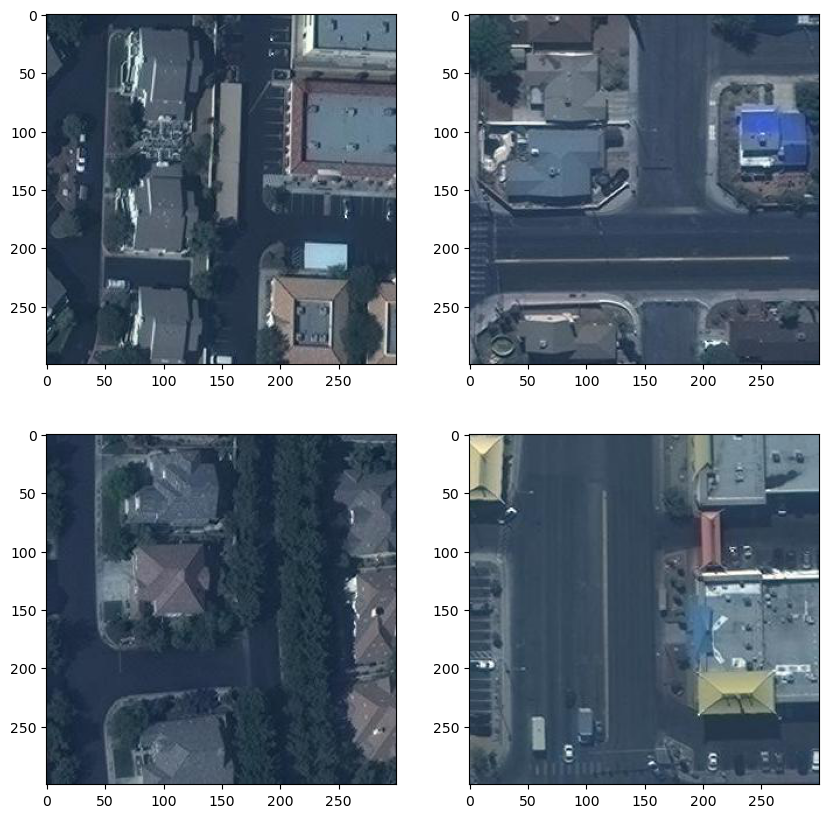

In [3]:
image_df = pd.DataFrame(annot_data['images'])
image_df.sample(3)
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (_, c_row) in zip(m_axs.flatten(), image_df.sample(4).iterrows()):
    img_data = imread(os.path.join(map_img_dir, c_row['file_name']))
    c_ax.imshow(img_data)

In [4]:
annot_df = pd.DataFrame(annot_data['annotations'])
annot_df.sample(3)

id  image_id                                       segmentation  \
210309   1979923    232263  [[243, 219, 243, 228, 247, 228, 248, 237, 263,...   
486719   1796879    210757  [[22.0, 207.0, 15.0, 207.0, 15.0, 192.0, 22.0,...   
2028345  2076564    243604  [[210.0, 288.0, 227.0, 288.0, 228.0, 300.0, 21...   

           area                        bbox  category_id  iscrowd  
210309   3682.0          [219, 172, 55, 91]          100        0  
486719    105.0    [15.0, 15.0, 192.0, 7.0]          100        0  
2028345   210.0  [210.0, 210.0, 78.0, 18.0]          100        0

In [5]:
full_df = pd.merge(annot_df, image_df, how='left', left_on = 'image_id', right_on='id').dropna()
print(image_df.shape[0], '+', annot_df.shape[0], '->', full_df.shape[0])
full_df.sample(2)

280741 + 2395553 -> 2395553


id_x  image_id                                       segmentation  \
77618    1787481    209640  [[144, 188, 144, 211, 104, 211, 104, 188, 89, ...   
2169244   812322     95295  [[145.00000000000003, 300.0, 146.0000000000000...   

           area                                               bbox  \
77618    5521.0                                  [77, 61, 134, 83]   
2169244   979.0  [145.00000000000003, 145.00000000000003, 154.9...   

         category_id  iscrowd    id_y         file_name  width  height  
77618            100        0  209640  000000209640.jpg    300     300  
2169244          100        0   95295  000000095295.jpg    300     300

In [6]:
def create_boxes(in_rows):
    #TODO: this seems to get a few of the boxes wrong so we stick to segmentation polygons instead
    box_list = []
    for _, in_row in in_rows.iterrows():
        # bbox from the coco standard
        (start_y, start_x, wid_y, wid_x) = in_row['bbox']
        
        box_list += [Rectangle((start_x, start_y), 
                         wid_y , wid_x
                         )]
    return box_list

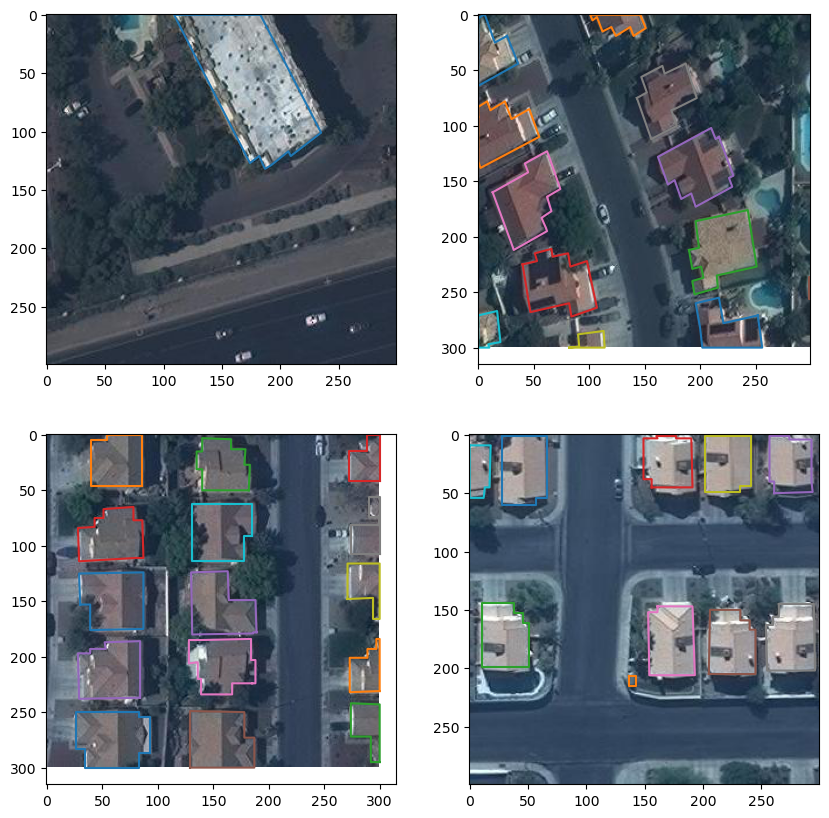

In [7]:
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (c_id, c_df) in zip(m_axs.flatten(), full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    #c_ax.add_collection(PatchCollection(create_boxes(c_df), alpha = 0.25, facecolor = 'red'))
    for _, c_row in c_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])

# Convert Polygons to Segmentations
We can use the `Path` function of matplotlib on a `np.meshgrid` of $x,y$ values in order to convert the polygon into a binary image to use as the segmentation.

In [8]:
from matplotlib.path import Path
from skimage.color import label2rgb
def rows_to_segmentation(in_img, in_df):
    xx, yy = np.meshgrid(range(in_img.shape[0]), 
                range(in_img.shape[1]),
               indexing='ij')
    out_img = np.zeros(in_img.shape[:2])
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])
        xy_path = Path(xy_vec)
        out_img += xy_path.contains_points(np.stack([yy.ravel(), 
                                                     xx.ravel()], -1)).reshape(out_img.shape)
    return out_img

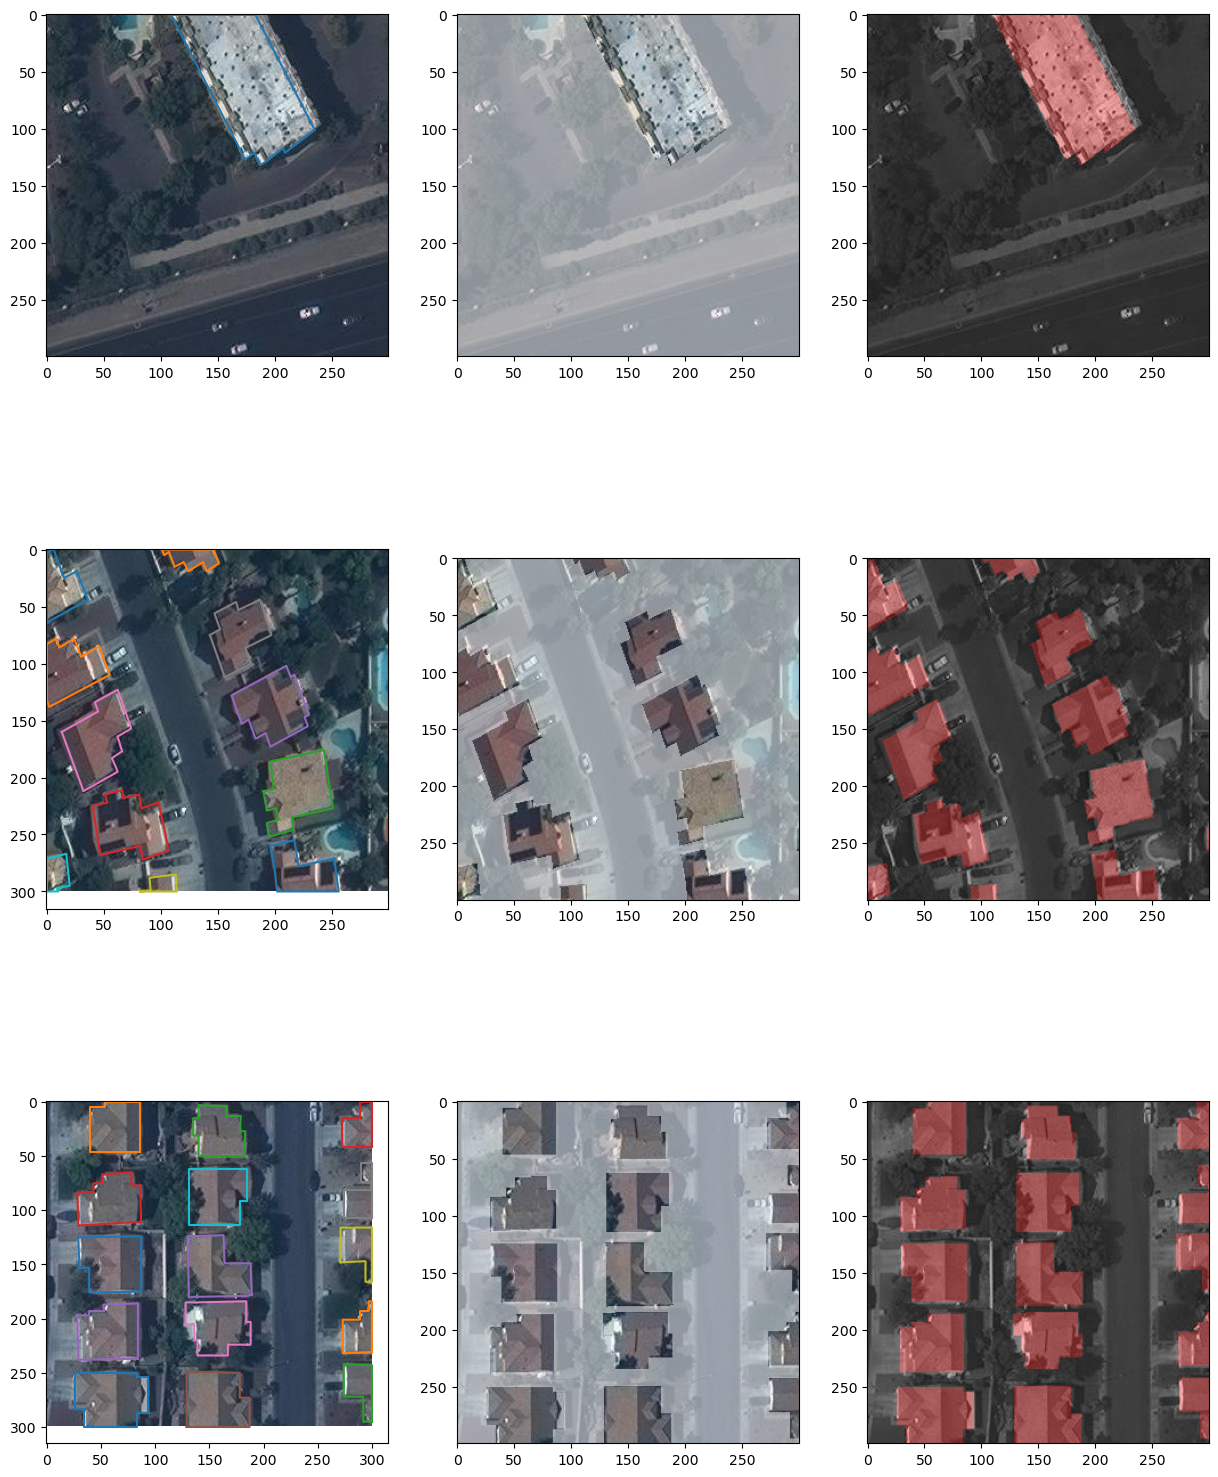

In [9]:
fig, m_axs = plt.subplots(3, 3, figsize = (15, 20))
for (c_ax, d_ax, f_ax), (c_id, c_df) in zip(m_axs,
                                      full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    out_img = rows_to_segmentation(img_data, c_df)
    rgba_img = np.concatenate([img_data, 
                               np.clip(np.expand_dims(127*out_img+127, -1), 0, 255).astype(np.uint8)
                              ], -1)
    d_ax.imshow(rgba_img)
    
    f_ax.imshow(label2rgb(image=img_data, label=out_img, bg_label = 0))

In [10]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(image_df['id'], test_size = 0.25)
train_df = full_df[full_df['image_id'].isin(train_ids)]
valid_df = full_df[full_df['image_id'].isin(valid_ids)]
print(train_df.shape[0], 'training boxes')
print(valid_df.shape[0], 'validation boxes')

1796739 training boxes
598814 validation boxes


In [11]:
def batch_img_gen(in_df, batch_size):
    all_groups = list(in_df.groupby('image_id'))
    out_img, out_seg = [], []
    while True:
        for (_, c_df) in np.random.permutation(all_groups):
            img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
            out_img += [img_data]
            out_seg += [np.expand_dims(rows_to_segmentation(img_data, c_df), -1)]
            if len(out_img)>=batch_size:
                yield (np.stack(out_img, 0)/255.0).astype(np.float32), np.stack(out_seg, 0).astype(np.float32)
                out_img, out_seg = [], []
valid_gen = batch_img_gen(valid_df, 8)            

In [12]:
def batch_img_gen_small_sample(in_df, batch_size):
    all_groups = list(in_df.groupby('image_id'))
    out_img, out_seg = [], []
    n=0
    while n<3:
        for (_, c_df) in np.random.permutation(all_groups):
            img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
            out_img += [img_data]
            out_seg += [np.expand_dims(rows_to_segmentation(img_data, c_df), -1)]
            if len(out_img)>=batch_size:
                yield (np.stack(out_img, 0)/255.0).astype(np.float32), np.stack(out_seg, 0).astype(np.float32)
                out_img, out_seg = [], []
        n+=1

/var/folders/r6/sgbmy7v556bcgn5krrfy1j3c0000gn/T/ipykernel_3990/1069371852.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):


x (8, 300, 300, 3) float32 0.0 1.0
y (8, 300, 300, 1) float32 0.0 1.0


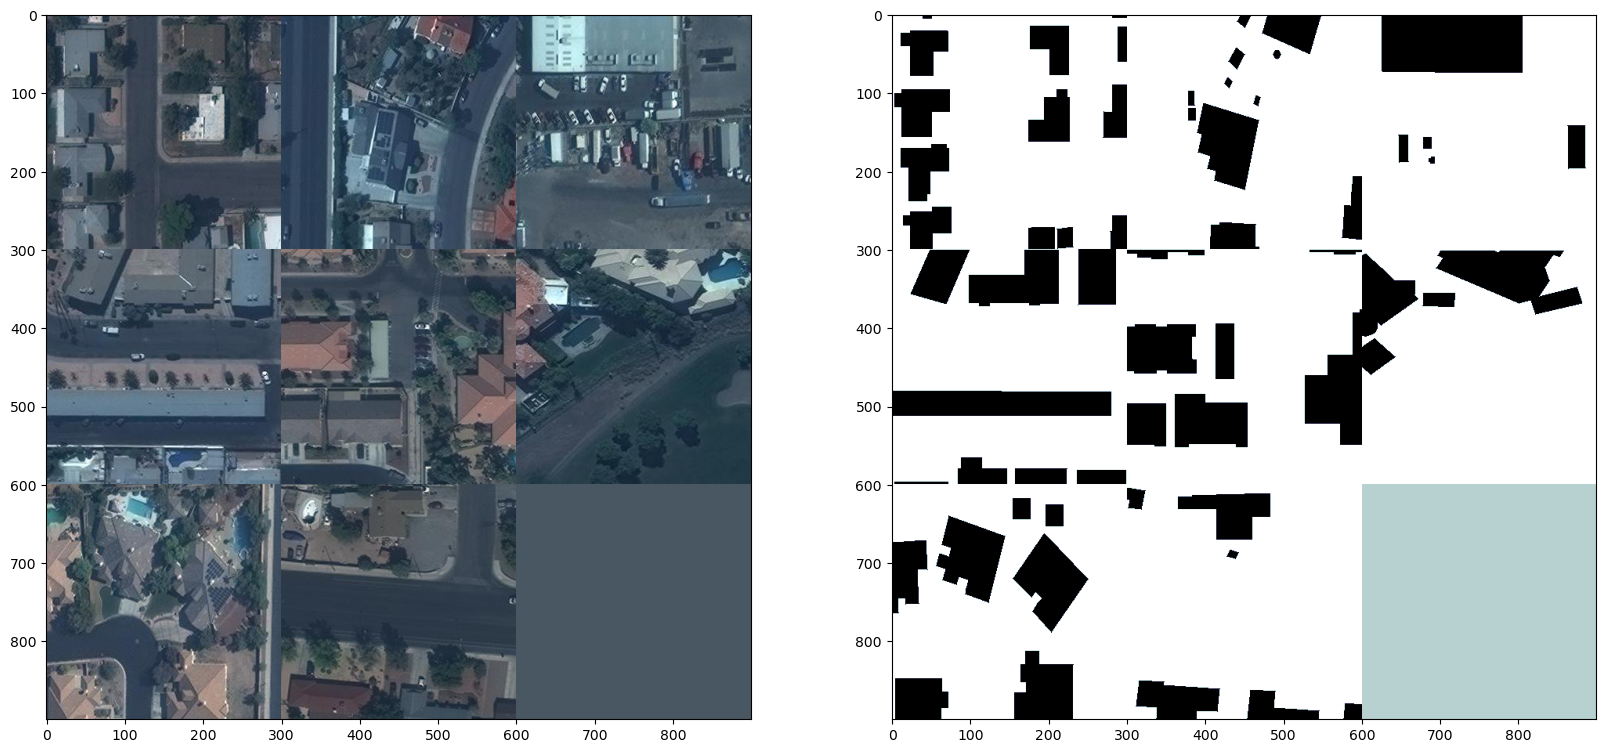

In [13]:
from skimage.util import montage
t_x, t_y = next(valid_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage(t_y[:, :, :, 0]), cmap = 'bone_r')

In [14]:
#from huggingface_hub import from_pretrained_keras

#model = from_pretrained_keras("deprem-ml/deprem-keras-satellite-semantic-mapping")
#model = from_pretrained_keras("deprem-keras-satellite-semantic-mapping")

In [15]:
# Load model directly
#from transformers import AutoFeatureExtractor, SegformerForSemanticSegmentation

#extractor = AutoFeatureExtractor.from_pretrained("deprem-ml/deprem_satellite_semantic_whu")
#model = SegformerForSemanticSegmentation.from_pretrained("deprem-ml/deprem_satellite_semantic_whu")

In [16]:
train_df

id_x  image_id                                       segmentation  \
0         460757     54062  [[300, 182, 297, 182, 296, 153, 300, 153, 300,...   
1         266461     31255  [[19.0, 234.0, 19.0, 245.0, 0.0, 246.0, 0.0, 2...   
2         313854     36754  [[133.0, 42.0, 133.0, 4.000000000000001, 197.0...   
3         278729     32649  [[125.0, 247.0, 125.0, 300.0, 37.0, 300.0, 36....   
4         509969     59769  [[200.0, 300.0, 212.0, 280.0, 227.0, 293.0, 23...   
...          ...       ...                                                ...   
2395545   156098     18378  [[133.0, 69.0, 133.0, 66.0, 118.99999999999999...   
2395546  1924654    225759  [[184.0, 90.0, 196.0, 90.0, 195.0, 70.0, 231.0...   
2395547  2066803    242458  [[48.0, 300.0, 48.0, 274.0, 42.0, 274.0, 42.0,...   
2395548   377477     44281  [[105.0, 300.0, 123.0, 293.0, 125.0, 300.0, 10...   
2395549   202579     23800  [[288.0, 72.00000000000001, 288.0, 85.00000000...   

           area                                               bbox  \
0         101.0                                 [182, 296, 118, 4]   
1         218.0                            [0.0, 0.0, 245.0, 19.0]   
2        2432.0            [4.000000000000001, 133.0, 193.0, 64.0]   
3        4647.0                          [37.0, 36.0, 263.0, 89.0]   
4        4122.0                        [200.0, 200.0, 100.0, 92.0]   
...         ...                                                ...   
2395545  3308.0  [53.0, 118.99999999999999, 80.0, 94.0000000000...   
2395546  2686.0                         [68.0, 184.0, 181.0, 65.0]   
2395547  2410.0                          [42.0, 42.0, 258.0, 55.0]   
2395548    71.0                        [105.0, 105.0, 195.0, 20.0]   
2395549  2118.0            [6.000000000000006, 252.0, 282.0, 36.0]   

         category_id  iscrowd    id_y         file_name  width  height  
0                100        0   54062  000000054062.jpg    300     300  
1                100        0   31255  000000031255.jpg    300     300  
2                100        0   36754  000000036754.jpg    300     300  
3                100        0   32649  000000032649.jpg    300     300  
4                100        0   59769  000000059769.jpg    300     300  
...              ...      ...     ...               ...    ...     ...  
2395545          100        0   18378  000000018378.jpg    300     300  
2395546          100        0  225759  000000225759.jpg    300     300  
2395547          100        0  242458  000000242458.jpg    300     300  
2395548          100        0   44281  000000044281.jpg    300     300  
2395549          100        0   23800  000000023800.jpg    300     300  

[1796739 rows x 11 columns]

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [18]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out


In [19]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        


    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out



In [20]:
# Inicjacja modelu
model = ResNet(BasicBlock, [2, 2, 2, 2])

# Ustawienie urządzenia (CPU lub GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Definicja funkcji straty i optymalizatora
criterion = nn.BCEWithLogitsLoss()  # Możesz zmienić odpowiednią funkcję straty dla segmentacji obrazu
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet34

# Trenowanie modelu
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for n in batch_img_gen_small_sample(train_df[:50], 8): 
        print('inputs batch shape', n[0].shape)
        print('labels batch shape', n[1].shape)
        inputs = torch.from_numpy(n[0])
        inputs = inputs.permute(0, 3, 1, 2) 
        labels = torch.from_numpy(n[1])
        labels = labels.permute(0, 3, 1, 2) 
        labels = labels[:, :, 0, 0]
        print('', inputs.shape)
        print('', labels.shape)

        inputs, labels = inputs.to(device), labels.to(device)

        print('inputs tensor shape', inputs.shape)
        print('labels tensor shape', labels.shape)

        optimizer.zero_grad()

        outputs = model(inputs)
        print('outputs shape: ', outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_df)}")

# Zapisz wytrenowany model
torch.save(model.state_dict(), "resnet_segmentation_model.pth")

/var/folders/r6/sgbmy7v556bcgn5krrfy1j3c0000gn/T/ipykernel_3990/2430300977.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):


inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (

/var/folders/r6/sgbmy7v556bcgn5krrfy1j3c0000gn/T/ipykernel_3990/2430300977.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):


outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torc

/var/folders/r6/sgbmy7v556bcgn5krrfy1j3c0000gn/T/ipykernel_3990/2430300977.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):


outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torc

/var/folders/r6/sgbmy7v556bcgn5krrfy1j3c0000gn/T/ipykernel_3990/2430300977.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):


outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torc

/var/folders/r6/sgbmy7v556bcgn5krrfy1j3c0000gn/T/ipykernel_3990/2430300977.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):


outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torc

/var/folders/r6/sgbmy7v556bcgn5krrfy1j3c0000gn/T/ipykernel_3990/2430300977.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):


outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torc

/var/folders/r6/sgbmy7v556bcgn5krrfy1j3c0000gn/T/ipykernel_3990/2430300977.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):


outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torc

/var/folders/r6/sgbmy7v556bcgn5krrfy1j3c0000gn/T/ipykernel_3990/2430300977.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):


outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torc

/var/folders/r6/sgbmy7v556bcgn5krrfy1j3c0000gn/T/ipykernel_3990/2430300977.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):


outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torc

/var/folders/r6/sgbmy7v556bcgn5krrfy1j3c0000gn/T/ipykernel_3990/2430300977.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):


outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torch.Size([8, 1])
inputs batch shape (8, 300, 300, 3)
labels batch shape (8, 300, 300, 1)
 torch.Size([8, 3, 300, 300])
 torch.Size([8, 1])
inputs tensor shape torch.Size([8, 3, 300, 300])
labels tensor shape torch.Size([8, 1])
outputs shape:  torc

/var/folders/r6/sgbmy7v556bcgn5krrfy1j3c0000gn/T/ipykernel_3990/2430300977.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):
/var/folders/r6/sgbmy7v556bcgn5krrfy1j3c0000gn/T/ipykernel_3990/2430300977.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):


inputs:  (8, 300, 300, 3)
labels:  (8, 300, 300, 1)
outputs:  torch.Size([8, 1])


IndexError: too many indices for tensor of dimension 2

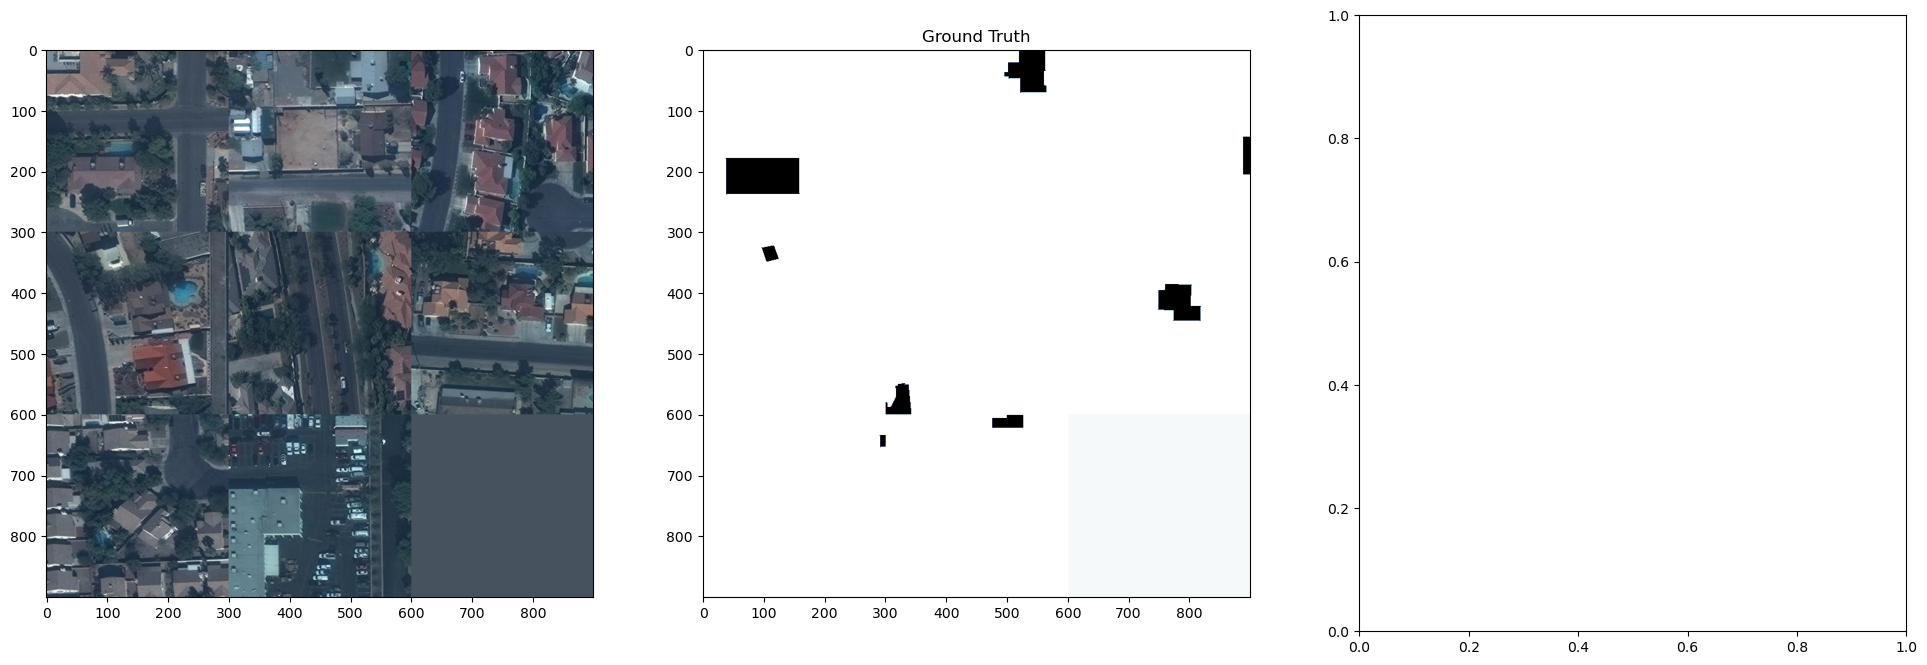

In [22]:
# Load the trained model state_dict
model.load_state_dict(torch.load('resnet_segmentation_model.pth'))

# Set the model to evaluation mode
model.eval()

# List to store predictions and ground truth labels
all_predictions = []
all_labels = []

# Make predictions for the validation set
with torch.no_grad():  # Disable gradient computation during inference
    for n in batch_img_gen_small_sample(valid_df[:50], 8): 

        inputs = torch.from_numpy(n[0])
        inputs = inputs.permute(0, 3, 1, 2) 
        labels = torch.from_numpy(n[1])
        labels = labels.permute(0, 3, 1, 2) 
        labels = labels[:, :, 0, 0]



        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the index of the class with the highest probability
        all_predictions.extend(predicted.cpu().numpy())  # Convert to NumPy array and append to the list
        all_labels.extend(labels.cpu().numpy())  # Convert to NumPy array and append to the list


# Convert predictions and labels to NumPy arrays for further analysis if needed
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

inputs, labels = next(batch_img_gen_small_sample(valid_df[:50], 8))
print('inputs: ', inputs.shape)
print('labels: ', labels.shape)
print('outputs: ', outputs.shape)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24, 8))
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(inputs))
ax2.imshow(montage(labels[:, :, :, 0]), cmap = 'bone_r')
ax2.set_title('Ground Truth')
ax3.imshow(montage(outputs[:, :, :, 0]), cmap = 'bone_r')
ax3.set_title('Prediction')
fig.savefig('pred_fig.png', dpi=300)
